In [1]:
import h5py
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import mplcursors
#import mpld3


def SaveDataToDF(f):
    myData = []
    myDataNames = []
    def saveDat(item):
        if 'Data' in str(f[item].id):
            data2use = f[item][()]
            if data2use.ndim == 2:#some groups have multiple columns and this messes up the translation to a df at the end of this function
                [a,b] = data2use.shape
                for col in np.arange(0,b):
                    myData.append(data2use[:,col])
                    dataName = (f[item].name).split('/')[-1] + str(col)
                    myDataNames.append(dataName)
            else:
                myData.append(f[item][()])
                dataName = (f[item].name).split('/')[-1]
                myDataNames.append(dataName)
        
    f.visit(saveDat)
    allData = pd.DataFrame(myData).T
    allData.columns = myDataNames
    f.close()
    return allData

# Spike Raster

In [2]:
f = h5py.File(os.path.join('network','biophysical_nodes.h5'), 'r')
nodesDF = SaveDataToDF(f)
cellLocations = pd.read_csv('cell_locations.csv')#this was for the old build, i'm just reading it instead of writing the list coz lazy
idNames = np.unique(nodesDF['node_type_id'])
cellNames = np.unique(cellLocations['Cell type'])
array = cellLocations['Cell type']
idxs = np.unique(cellLocations['Cell type'],return_index=True)[1]
cellNames = [array[index] for index in sorted(idxs)]#use the names in the order in which the id's appear

nodesDF = nodesDF.replace({'node_type_id':idNames},{'node_type_id':cellNames})

f = h5py.File(os.path.join('output','spikes.h5'), 'r')
spikesDF = SaveDataToDF(f) 

namesList = []
for i in range(len(spikesDF['node_ids'])):
    namesList.append(nodesDF['node_type_id'][spikesDF['node_ids'][i]])
spikesDFM = pd.concat([spikesDF,pd.Series(namesList)],axis=1)
spikesDFM.columns = ['node_ids','timestamps','node_type_id']
spikesDFMM = spikesDFM.merge(nodesDF[['node_id','positions2']], left_on='node_ids',right_on='node_id',how='left')

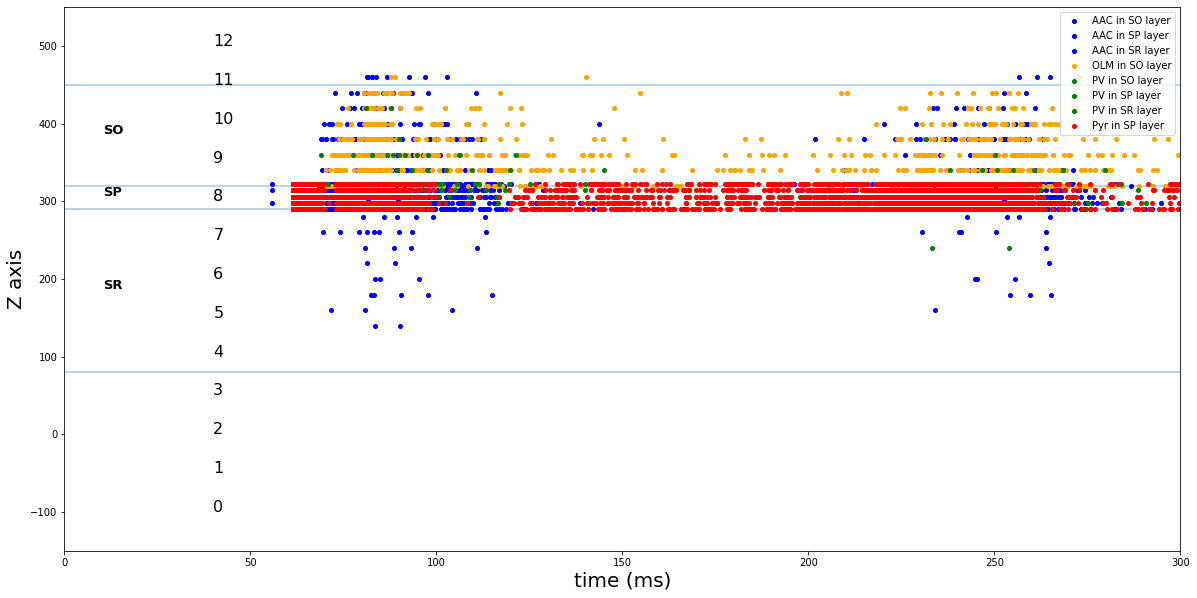

In [3]:
plt.figure(figsize=(20,10))

xmin,xmax = 0,300
ymin,ymax = -150, 550

electrode_pos = pd.read_csv("biophys_components/recXelectrodes/linear_electrode.csv",delimiter=" ")
groups = spikesDFMM.groupby('node_type_id')
color_map = {
    'AAC': 'blue',
    'OLM': 'orange',
    'Pyr': 'red',
    'PV' : 'green'
}
for name, group in groups:
    color = color_map.get(name.split(' ')[0])
    plt.plot(group.timestamps, group.positions2,marker='o',linestyle="",markersize=4, label=name,color=color)
    
plt.legend(loc='upper right')
plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])
plt.ylabel('Z axis',size=20)
plt.xlabel('time (ms)',size=20)

layers_dict = {'SO': (320,450),
              'SP' : (290,320),
              'SR' : (80,290)}

for key in layers_dict:
    plt.hlines(layers_dict[key][0],xmin = 0, xmax = xmax,alpha = 0.4)
    if key == 'SO':
        plt.hlines(layers_dict[key][1],xmin = 0, xmax = xmax,alpha = 0.4)

for key in layers_dict:
    plt.annotate(key,
                xy=(10, (layers_dict[key][0] + layers_dict[key][1])/2),
                xytext=(1.5, 1.5), textcoords='offset points',fontsize=13,weight='bold')
    
for i in range(electrode_pos.shape[0]):
    plt.annotate(str(i),xy=(40,electrode_pos['z_pos'].iloc[i]),xytext=(0,0),textcoords='offset points',fontsize=16)

    
# x = np.array(spikesDFMM['timestamps'])
# y = np.array(spikesDFMM['positions2'])
# scatter = plt.scatter(x,y)
# mplcursors.cursor(scatter)

plt.show()

### number of spikes of each node type id

In [4]:

idTypes = pd.DataFrame(nodesDF['node_type_id'][spikesDF['node_ids']])
idTypes.columns = ['node_type_id']
idTypes.index = range(0,len(spikesDF))#concat does not handle different indices, even if ignore_index=True for some reason

spikesDFM = pd.concat([spikesDF,idTypes],axis=1)
print(spikesDFM.keys())
spikesDFM.groupby('node_type_id').apply(len)

Index(['node_ids', 'timestamps', 'node_type_id'], dtype='object')


node_type_id
AAC in SO layer     353
AAC in SP layer    1731
AAC in SR layer      55
OLM in SO layer     987
PV in SO layer       31
PV in SP layer      140
PV in SR layer        2
Pyr in SP layer    9304
dtype: int64

### number of cells in each layer

In [5]:
nodesDF.groupby('node_type_id').apply(len)

node_type_id
AAC in SO layer      156
AAC in SP layer      457
AAC in SR layer       40
OLM in SO layer      663
PV in SO layer       211
PV in SP layer       622
PV in SR layer        53
Pyr in SP layer    17800
dtype: int64

# save interactive graph to find node_ids

In [6]:
import plotly.express as px


In [7]:
plt.figure(figsize=(20,10))

xmin,xmax = 0,300
ymin,ymax = -150, 550

electrode_pos = pd.read_csv("biophys_components/recXelectrodes/linear_electrode.csv",delimiter=" ")


fig = px.scatter(spikesDFMM, x='timestamps',y='positions2', color='node_type_id',hover_data=['node_ids'])
layers_dict = {'SO': (320, 450), 'SP': (290, 320), 'SR': (80, 290)}

for key, value in layers_dict.items():
    fig.add_shape(type='line', x0=min(spikesDFMM['timestamps']), x1=max(spikesDFMM['timestamps']), y0=value[0], y1=value[0],
                  line=dict(color='black', width=1, dash='solid'))
    if key == 'SO':
        fig.add_shape(type='line', x0=min(spikesDFMM['timestamps']), x1=max(spikesDFMM['timestamps']), y0=value[1], y1=value[1],
                      line=dict(color='black', width=1, dash='solid'))
              
        
# Add dots
dot_trace = dict(
    x=[40 for i in range(13)],  # Replace x_val with the appropriate x-coordinate for the dots
    y=electrode_pos['z_pos'],  # Specify the y-coordinates of the dots
    mode='markers',
    marker=dict(
        symbol='circle',
        size=5,
        color='black'
    ),
)

fig.add_trace(dot_trace)
        
fig.update_layout(xaxis_range=[xmin, xmax], yaxis_range=[ymin, ymax])

fig.write_html('interactive_raster.html')


<Figure size 1440x720 with 0 Axes>

# ECP

In [8]:
f = h5py.File('output/ecp.h5', 'r')
data = f['ecp/data'][()]
time = f['ecp/time'][()]
f.close()

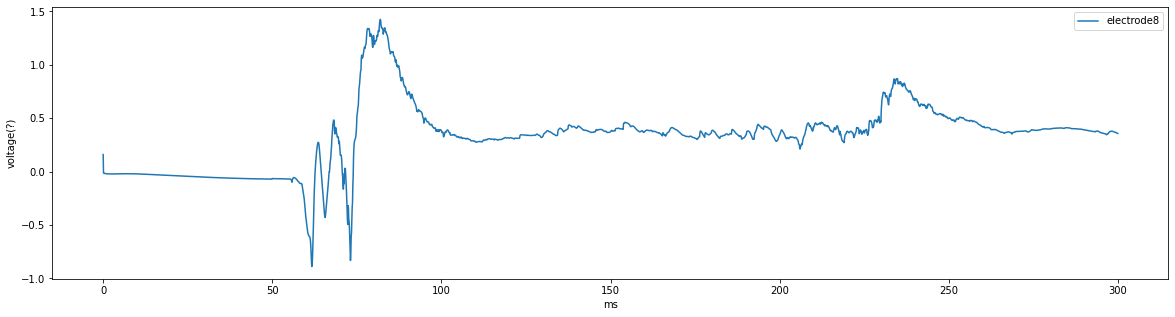

In [9]:

xmin,xmax = 0,300
start,end = 0, 12000

plt.figure(figsize=(20,5))
for i in range(8,9):
    plt.plot(np.arange(time[0],time[1],time[2])[start:end],data[start:end,i],label=f"electrode{i}")

plt.xlabel('ms')
plt.ylabel('voltage(?)')
plt.legend()
plt.show()

# Frequency Content

In [10]:
from scipy import signal
from scipy.signal import hilbert
import numpy as np

### filtered

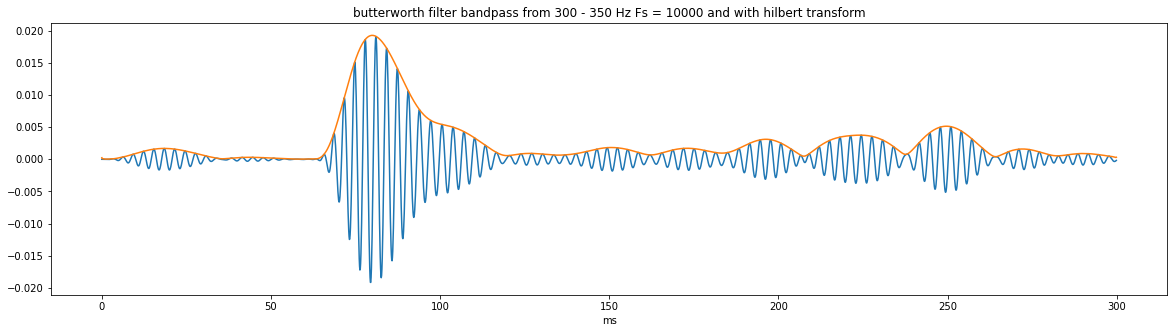

In [11]:
start,end = 0, 10000
Fs = 10000

lf, hf = 300,350

sos = signal.butter(4, [int(lf/(10000/Fs)),int(hf/(10000/Fs))], btype='bandpass', fs=10000, output='sos',analog=False)

filtered = signal.sosfilt(sos, data[start:end,0])
plt.figure(figsize=(20,5))
plt.plot(np.arange(time[0],time[1],time[2])[start:end],filtered)
analytical_signal = hilbert(filtered)
amplitude_envelope = np.abs(analytical_signal)
plt.plot(np.arange(time[0],time[1],time[2])[start:end],amplitude_envelope)
plt.title(f'butterworth filter bandpass from {lf} - {hf} Hz Fs = 10000 and with hilbert transform')
plt.xlabel('ms')

plt.show()

### psd

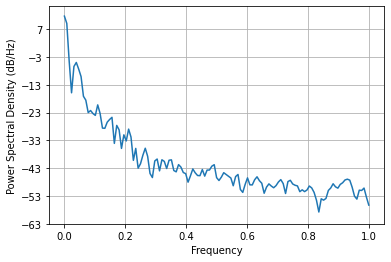

In [12]:
plt.psd(data[:,8])
plt.show()

### wavelet

In [13]:
import pywt
from scipy import signal

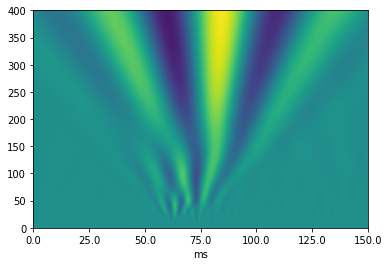

In [14]:

electrode_number = 8

plt_time = np.arange(time[0],time[1],time[2])[start:end]
plt_data = data[start:end,electrode_number]


t = plt_time
sig = plt_data
widths = np.arange(1,1000)
cwtmatr, freqs = pywt.cwt(sig, widths, 'morl')
plt.imshow(cwtmatr,   aspect='auto',
           vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max()) 

plt.ylim([0,400])
plt.xlim([0,1500])
tick_locations = np.array([0, 250, 500, 750, 1000, 1250, 1500])  # Adjust as needed
tick_labels = tick_locations / 10  # Divide by the desired scaling factor

# Set the x-axis ticks
plt.xticks(tick_locations, tick_labels)
plt.xlabel('ms')
plt.show()

# Convergence

In [15]:
f = h5py.File(os.path.join('updated_conns','biophysical_biophysical_edges.h5'))
synapsesDF = SaveDataToDF(f)

In [16]:
srcs = nodesDF.iloc[synapsesDF['source_node_id']]
trgts = nodesDF.iloc[synapsesDF['target_node_id']]

def get_sids_to_tids(synapsesDF,src,trgt):

    sids = list(set(trgts[trgts['node_type_id'].str.contains(src)]['node_id']))
    tids = list(set(srcs[srcs['node_type_id'].str.contains(trgt)]['node_id']))
    
    sid_to_tid = synapsesDF[(synapsesDF['source_node_id'].isin(sids)) & (synapsesDF['target_node_id'].isin(tids))]
    num_sids = len(np.unique(sid_to_tid['source_node_id']))
    if num_sids == 0:
        return 0, 0
    return num_sids, sid_to_tid

key_names = [('AAC','Pyr'),
             ('Pyr','AAC'),
             ('PV','Pyr'),
             ('Pyr','PV'),
             ('PV','AAC'),
             ('PV','PV'),
             ('OLM','Pyr'),
             ('OLM','AAC'),
             ('OLM','PV'),
             ('OLM','OLM'),
             ('Pyr','OLM')
              ]

Text(0, 0.5, 'convergence')

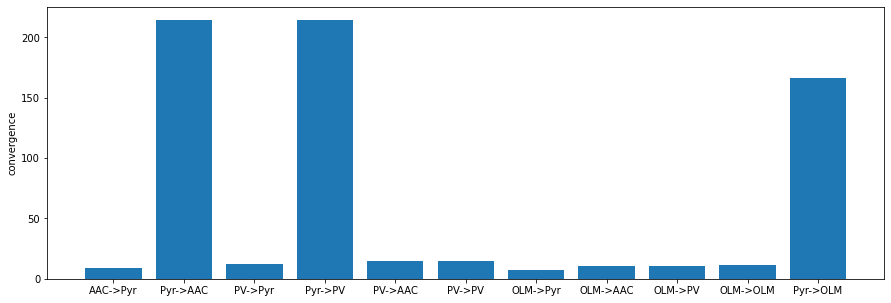

In [17]:
s2t_dict = {}

for pair in key_names:
    num_sids, sids_to_tids = get_sids_to_tids(synapsesDF,pair[0],pair[1])
    if num_sids == 0:
        continue
    tids_nums = pd.DataFrame(sids_to_tids.groupby('target_node_id').apply(len))
    avg_num_connections = np.mean(tids_nums)
                                              
    s2t_dict.update({f"{pair[0]}->{pair[1]}": float(avg_num_connections) })
keys, values = list(s2t_dict.keys()), list(s2t_dict.values())
plt.figure(figsize=(15,5))
plt.bar(keys,values)
plt.ylabel('convergence')

In [18]:
s2t_dict

{'AAC->Pyr': 9.231734068282806,
 'Pyr->AAC': 214.0490045941807,
 'PV->Pyr': 12.599561748511068,
 'Pyr->PV': 214.41873589164786,
 'PV->AAC': 14.911179173047474,
 'PV->PV': 15.149152542372882,
 'OLM->Pyr': 7.227631282398017,
 'OLM->AAC': 10.323574730354391,
 'OLM->PV': 10.324232081911262,
 'OLM->OLM': 11.605740181268882,
 'Pyr->OLM': 166.56410256410257}

# synaptic weights

In [19]:
#for each source, find all of its targets, and their associated weights and their distance
def get_src_to_trgt_df(nodesDF,synapsesDF,src,trgt):
    src_ids = nodesDF[nodesDF['node_type_id'].str.contains(src)]['node_id']
    trgt_ids = nodesDF[nodesDF['node_type_id'].str.contains(trgt)]['node_id']
    src_df = synapsesDF[synapsesDF['source_node_id'].isin(src_ids)]
    trgt_df = synapsesDF[synapsesDF['target_node_id'].isin(trgt_ids)]
    src_to_trgt = trgt_df[trgt_df['source_node_id'].isin(src_df['source_node_id'])]
    return src_to_trgt



In [20]:
def get_s2t_distances(nodesDF,synapsesDF,src,trgt):
    df = get_src_to_trgt_df(nodesDF,synapsesDF,src,trgt)
    unique_src_ids = np.unique(df['source_node_id'])
    all_dist = []
    for i in range(len(unique_src_ids)):
        source = int(unique_src_ids[i])

        s2t_df = df[df['source_node_id'] == source] # data frame with all source target pairs for 1 source
        s_x, s_y, s_z = nodesDF['positions0'].iloc[source],nodesDF['positions1'].iloc[source],nodesDF['positions2'].iloc[source]
        all_src_positions = np.vstack((s_x,s_y,s_z)).T  # position of this particular source


        target_positions = nodesDF.iloc[s2t_df['target_node_id']] # the nodesDF for all the targets for this source
        t_x, t_y, t_z = target_positions['positions0'],target_positions['positions1'],target_positions['positions2']
        all_trgt_positions = np.vstack((t_x,t_y,t_z)).T # positions of all the targets for this one source
        squared_distances = np.sum((all_src_positions - all_trgt_positions) ** 2,axis=1)
        euclidean_distances = np.sqrt(squared_distances)

        all_dist.append(euclidean_distances.flatten())
    return np.concatenate(all_dist)

In [21]:
syn_dist_dict = {}
for pair in key_names:
    print(pair)
    dists = get_s2t_distances(nodesDF,synapsesDF,pair[0],pair[1])
    syn_dist_dict.update({f"{pair[0]}->{pair[1]}": dists})

('AAC', 'Pyr')
('Pyr', 'AAC')
('PV', 'Pyr')
('Pyr', 'PV')
('PV', 'AAC')
('PV', 'PV')
('OLM', 'Pyr')
('OLM', 'AAC')
('OLM', 'PV')
('OLM', 'OLM')
('Pyr', 'OLM')


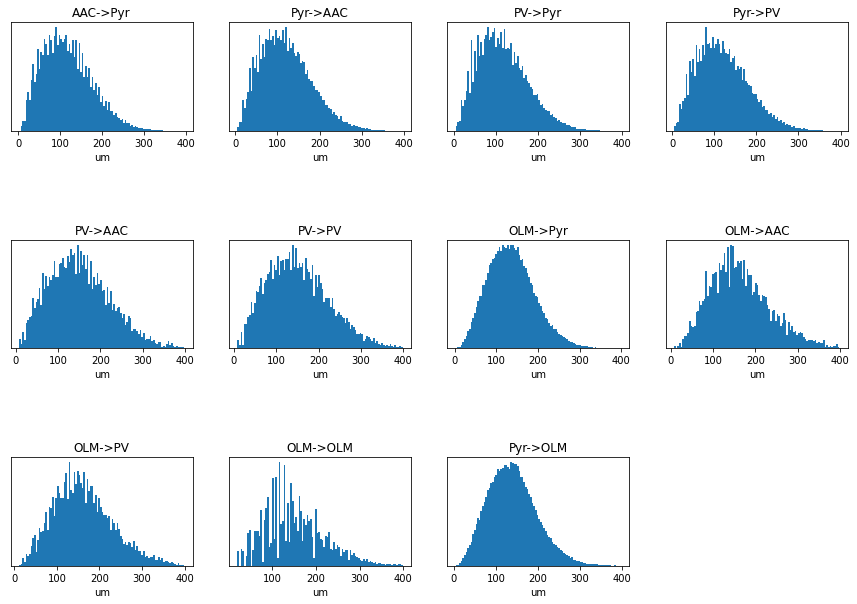

In [22]:
#need to scale the histogram so that it is the bin size / # possible connections. that's conn prob, right?
#then compare with the input specifications. that is, make a pdf of these and compare the fit with the chosen pdf for bmtk
fig,axs = plt.subplots(3,4,figsize=(15,10))
axs = axs.flatten()
keys = list(syn_dist_dict.keys())
for i, (key, data) in enumerate(syn_dist_dict.items()):
    ax = axs[i]
    ax.hist(data,bins=100)
    ax.set_title(f"{key}")
    ax.set_xlabel('um')
    ax.set_yticks([])
for ax in axs[len(syn_dist_dict):]:
    ax.remove()
    
plt.subplots_adjust(hspace=1)

In [23]:
syn_weights_dict = {}
for pair in key_names:
    weights = get_src_to_trgt_df(nodesDF,synapsesDF,pair[0],pair[1])['syn_weight']
    weights.columns = ['syn_weight','Nans']
    weights = weights.drop('Nans',axis=1)
    syn_weights_dict.update({f"{pair[0]}->{pair[1]}": weights})

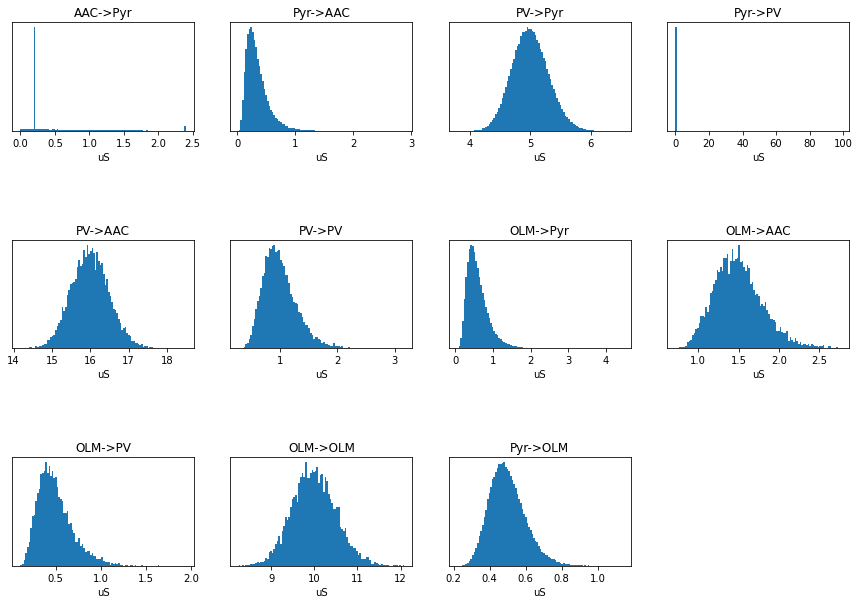

In [24]:
fig,axs = plt.subplots(3,4,figsize=(15,10))
axs = axs.flatten()
keys = list(syn_weights_dict.keys())
for i, (key, data) in enumerate(syn_weights_dict.items()):
    ax = axs[i]
    ax.hist(data,bins=100)
    ax.set_title(f"{key}")
    ax.set_xlabel('uS')
    ax.set_yticks([])
for ax in axs[len(syn_weights_dict):]:
    ax.remove()
    
plt.subplots_adjust(hspace=1)